In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
random.seed(42)

In [3]:
NUM_SAMPLES = 9229

numbers_all = []
for file in os.listdir(os.fsencode("./dataset/rgb")):
    numbers_all.append(os.fsdecode(file)[:5])

numbers = random.sample(numbers_all, NUM_SAMPLES)

grays = np.zeros((NUM_SAMPLES, 480, 640), dtype=np.uint8)
square_distances = np.zeros((NUM_SAMPLES, 480, 640), dtype=np.float32)
i_ys = np.zeros((NUM_SAMPLES,), dtype=np.uint32)

for i, number in enumerate(numbers):
    bgr_path = "./dataset/rgb/{}.png".format(number)
    boundary_path = "./dataset/boundary/{}_edge.png".format(number)

    bgr = cv.imread(bgr_path)
    boundary = cv.imread(boundary_path)[:, :, 0].astype(np.uint8)
    distance = cv.distanceTransform(cv.bitwise_not(boundary), cv.DIST_L1, maskSize=3)
    
    grays[i] = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY).astype(np.uint8)
    square_distances[i] = distance * distance
    i_ys[i] = np.sum(boundary) / 255

In [4]:
def figure_of_merit(x, square_distance, i_y, a):
    i_x = np.sum(x)
    i_n = max(i_x, i_y)
    return np.sum(x / (1 + square_distance * a)) / i_n

In [5]:
RESOLUTION = 30

# figures_of_merit = np.zeros((NUM_SAMPLES, RESOLUTION, RESOLUTION), dtype=np.float32)
ext_figures_of_merit = np.zeros((NUM_SAMPLES, RESOLUTION, RESOLUTION), dtype=np.float32)
bounds = np.linspace(0, 255, RESOLUTION, dtype=np.float32)

for i, lower in enumerate(bounds):
    for j, upper in enumerate(bounds):
        if i >= j:
            continue

        for k, gray, square_distance, i_y in zip(range(NUM_SAMPLES), grays, square_distances, i_ys):
            edges = cv.Canny(gray, lower, upper) // 255
            blank = np.zeros((480, 640), dtype='uint8')
            contours, hierarchies = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            ext_contours = cv.drawContours(blank, contours, -1, (255, 255, 255), 1)
            # figures_of_merit[k, j, i] = figure_of_merit(edges, square_distance, i_y, 1/9)
            ext_figures_of_merit[k, j, i] = figure_of_merit(ext_contours, square_distance, i_y, 1/9)

In [6]:
# means = np.mean(figures_of_merit, axis=0)
# stds = np.std(figures_of_merit, axis=0)
# max_index = np.unravel_index(np.argmax(means), means.shape)
# print(np.max(means), ' ', bounds[max_index[0]], bounds[max_index[1]])

# plt.figure(figsize=(8, 6))
# plt.imshow(
#     means,
#     cmap='hot',
#     origin='lower',
#     interpolation='nearest',
#     extent=[bounds[0], bounds[-1], bounds[0], bounds[-1]],
# )
# plt.xlabel('Lower Bound')
# plt.ylabel('Upper Bound')
# plt.title('Heatmap of Mean Figures of Merit')
# plt.colorbar()
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.imshow(
#     stds,
#     cmap='hot',
#     origin='lower',
#     interpolation='nearest',
#     extent=[bounds[0], bounds[-1], bounds[0], bounds[-1]],
# )
# plt.xlabel('Lower Bound')
# plt.ylabel('Upper Bound')
# plt.title('Heatmap of Sandard Deviation of Figures of Merit')
# plt.colorbar()
# plt.show()

0.14729299   228.6207 219.82759


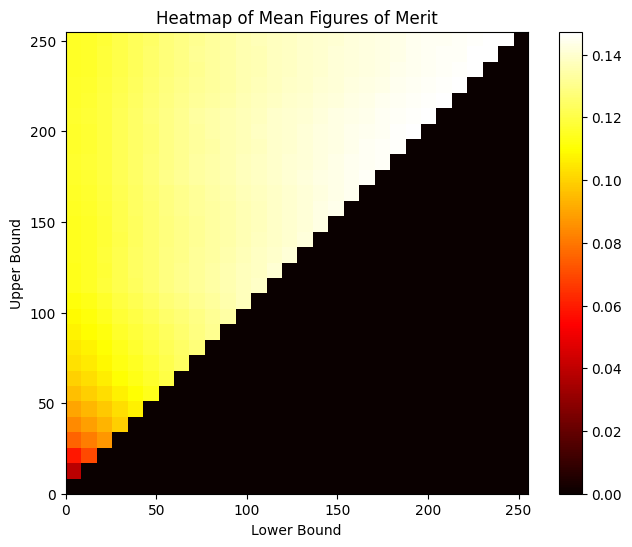

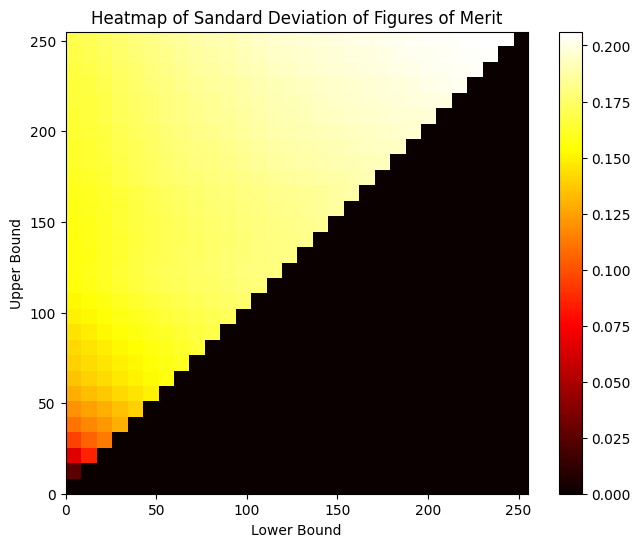

In [11]:
means = np.mean(ext_figures_of_merit, axis=0)
stds = np.std(ext_figures_of_merit, axis=0)
max_index = np.unravel_index(np.argmax(means), means.shape)
print(np.max(means), ' ', bounds[max_index[0]], bounds[max_index[1]])

plt.figure(figsize=(8, 6))
plt.imshow(
    means,
    cmap='hot',
    origin='lower',
    interpolation='nearest',
    extent=[bounds[0], bounds[-1], bounds[0], bounds[-1]],
)
plt.xlabel('Lower Bound')
plt.ylabel('Upper Bound')
plt.title('Heatmap of Mean Figures of Merit')
plt.colorbar()
plt.savefig('report_images/mean_fom.png')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(
    stds,
    cmap='hot',
    origin='lower',
    interpolation='nearest',
    extent=[bounds[0], bounds[-1], bounds[0], bounds[-1]],
)
plt.xlabel('Lower Bound')
plt.ylabel('Upper Bound')
plt.title('Heatmap of Sandard Deviation of Figures of Merit')
plt.colorbar()
plt.savefig('report_images/std_fom.png')
plt.show()